<a href="https://colab.research.google.com/github/lucjalucja/analysis/blob/main/softreport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
# Load data
data = pd.read_csv("Soft Skillet_ October Data Live - Activity Data vOct.csv")
add = pd.read_csv("outcome.csv")
data = pd.merge(data, add, on='Customer Account ID')
data.head()

,Activity ID,Date,Person,Call Connect,Pitch,Disposition,Customer Account ID,Outcome
0,01pElO8,9/12/2024,Owner,Connected,AI,No interest,10898,Loss
1,02cNE8F,9/3/2024,Manager,Connected,Operator,Deferred to Other Stakeholder,26600,Open
2,0498JpwY8S,9/6/2024,Owner,Connected,AI,Engaged,29419,Loss
3,06Q6UJH,9/9/2024,Manager,Connected,Operator,No Interest,97655,Loss
4,07IT4x0,9/5/2024,Manager,Connected,Smooth,No Interest,57549,Loss


In [ ]:
# Filter out rows where 'person', 'pitch', and 'disposition' are NaN
filtered_data = data.dropna(subset=['Person', 'Pitch', 'Disposition'], how='all')
filtered_data.head()

,Activity ID,Date,Person,Call Connect,Pitch,Disposition,Customer Account ID,Outcome
0,01pElO8,9/12/2024,Owner,Connected,AI,No interest,10898,Loss
1,02cNE8F,9/3/2024,Manager,Connected,Operator,Deferred to Other Stakeholder,26600,Open
2,0498JpwY8S,9/6/2024,Owner,Connected,AI,Engaged,29419,Loss
3,06Q6UJH,9/9/2024,Manager,Connected,Operator,No Interest,97655,Loss
4,07IT4x0,9/5/2024,Manager,Connected,Smooth,No Interest,57549,Loss


In [ ]:
# Group by 'Person' and 'Pitch' to count the number of successful dispositions
success_counts = filtered_data[filtered_data['Outcome'] == 'Win'].groupby(['Person', 'Pitch'])['Disposition'].count().reset_index(name='SuccessCount')

# Group by 'Person' and 'Pitch' to count the total number of dispositions
total_counts = filtered_data.groupby(['Person', 'Pitch'])['Disposition'].count().reset_index(name='TotalCount')

# Merge success and total counts, using 'outer' join to include all combinations
merged_counts = pd.merge(success_counts, total_counts, on=['Person', 'Pitch'], how='outer')

# Fill NaN values in 'SuccessCount' with 0 (for combinations with no successes)
merged_counts['SuccessCount'] = merged_counts['SuccessCount'].fillna(0)

# Calculate the success rate
merged_counts['SuccessRate'] = (merged_counts['SuccessCount'] / merged_counts['TotalCount']) * 100


print("Success Rates for all combinations:")
merged_counts

Success Rates for all combinations:


,Person,Pitch,SuccessCount,TotalCount,SuccessRate
0,Manager,AI,12,103,11.650485
1,Manager,Operator,6,196,3.061224
2,Manager,Smooth,5,143,3.496503
3,Owner,AI,13,68,19.117647
4,Owner,Operator,7,67,10.447761
5,Owner,Smooth,15,70,21.428571


In [ ]:
# Install necessary libraries for transcription
!pip install pydub
!pip install SpeechRecognition

In [ ]:
import os
import subprocess
from pydub import AudioSegment
import speech_recognition as sr

def transcribe_audio(file_path):
  """
  Transcribes an audio file using Google Speech Recognition.

  Args:
    file_path: The path to the audio file.

  Returns:
    The transcribed text, or None if transcription fails.
  """
  recognizer = sr.Recognizer()
  try:
    # Explicitly convert to WAV using pydub
    audio = AudioSegment.from_file(file_path)
    audio.export("temp.wav", format="wav")  # Export to a temporary WAV file

    with sr.AudioFile("temp.wav") as source:
      audio_data = recognizer.record(source)
      text = recognizer.recognize_google(audio_data)

    os.remove("temp.wav")  # Remove the temporary file
    return text

  except sr.UnknownValueError:
    print(f"Google Speech Recognition could not understand audio in {file_path}")
    return None
  except sr.RequestError as e:
    print(f"Could not request results from Google Speech Recognition service; {e}")
    return None
  except Exception as e:
    print(f"An error occurred: {e}")  # Catch and print other exceptions
    return None


def convert_mov_to_wav(mov_file_path):
    """Converts .mov file to .wav using ffmpeg"""
    wav_file_path = mov_file_path.replace(".mov", ".wav")
    try:
        subprocess.run(["ffmpeg", "-i", mov_file_path, wav_file_path], check=True)
        return wav_file_path
    except subprocess.CalledProcessError as e:
        print(f"Error converting .mov to .wav: {e}")
        return None

def process_files_in_directory(directory):
    """Processes all .mov and .mp3 files in a directory"""
    for filename in os.listdir(directory):
        if filename.endswith(".mov"):
            file_path = os.path.join(directory, filename)
            wav_file_path = convert_mov_to_wav(file_path)
            if wav_file_path:
                transcription = transcribe_audio(wav_file_path)
                if transcription:
                    output_file_path = file_path.replace(".mov", ".txt")
                    with open(output_file_path, "w") as f:
                        f.write(transcription)
        elif filename.endswith(".mp3"):
            file_path = os.path.join(directory, filename)
            transcription = transcribe_audio(file_path) # transcribe_audio directly for .mp3 files
            if transcription:
                output_file_path = file_path.replace(".mp3", ".txt")
                with open(output_file_path, "w") as f:
                    f.write(transcription)


directory_to_process = "/content/additional"  # path to directory with recordings
process_files_in_directory(directory_to_process)

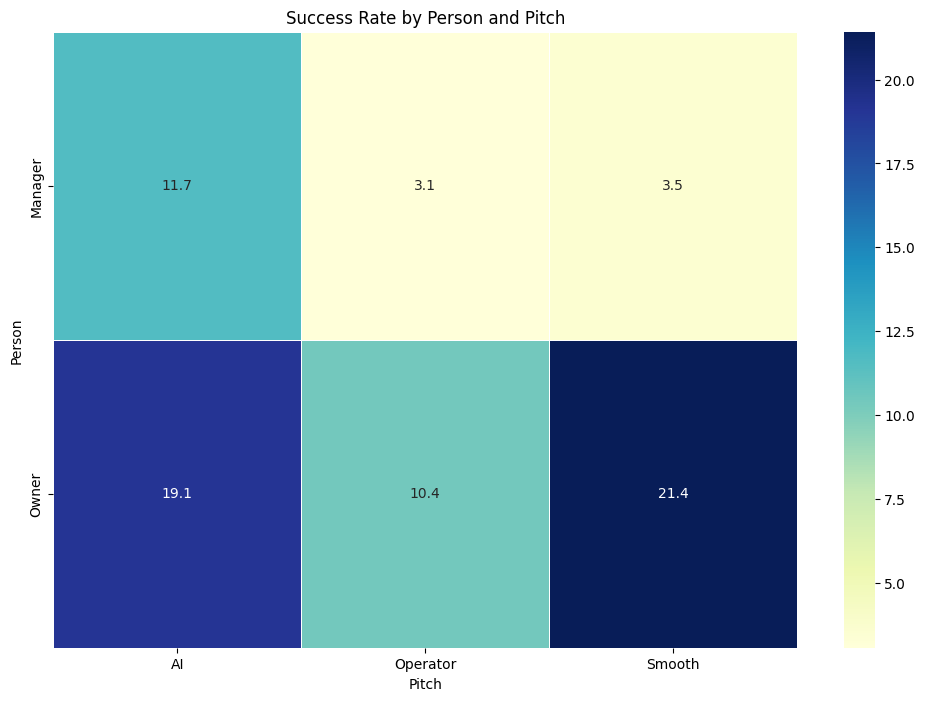

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# pivot table for plotting
pivot_table = merged_counts.pivot(index='Person', columns='Pitch', values='SuccessRate')

# heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title("Success Rate by Person and Pitch")
plt.xlabel("Pitch")
plt.ylabel("Person")
plt.show()

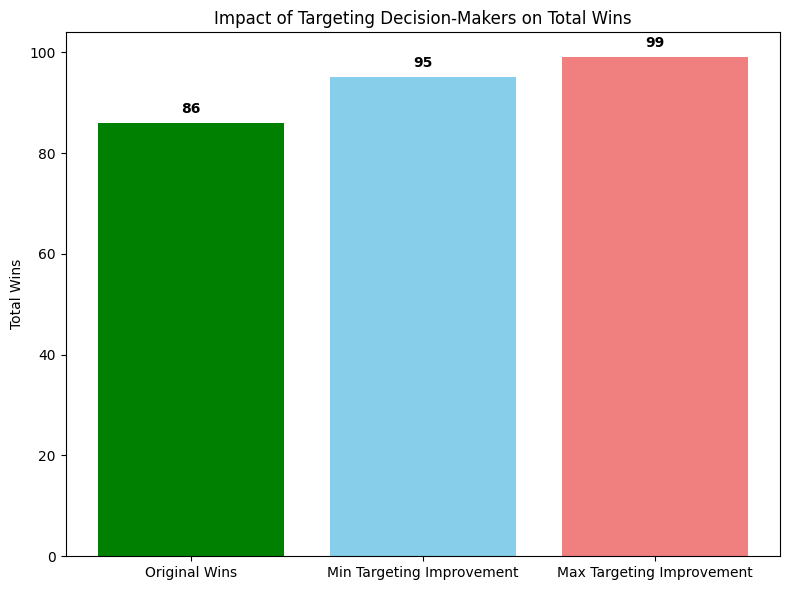

In [ ]:
import matplotlib.pyplot as plt

# Data for Targeting Decision-Makers improvement
original_wins = 86
min_targeting_improvement = 9  # Minimum additional wins expected from targeting owners
max_targeting_improvement = 13  # Maximum additional wins expected from targeting owners

# Calculate total wins after targeting decision-makers
min_total_wins = original_wins + min_targeting_improvement
max_total_wins = original_wins + max_targeting_improvement

# Plot
labels = ['Original Wins', 'Min Targeting Improvement', 'Max Targeting Improvement']
values = [original_wins, min_total_wins, max_total_wins]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['green', 'skyblue', 'lightcoral'])

# Add labels and title
plt.title('Impact of Targeting Decision-Makers on Total Wins')
plt.ylabel('Total Wins')

# Annotate bars with values
for i, v in enumerate(values):
    plt.text(i, v + 2, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


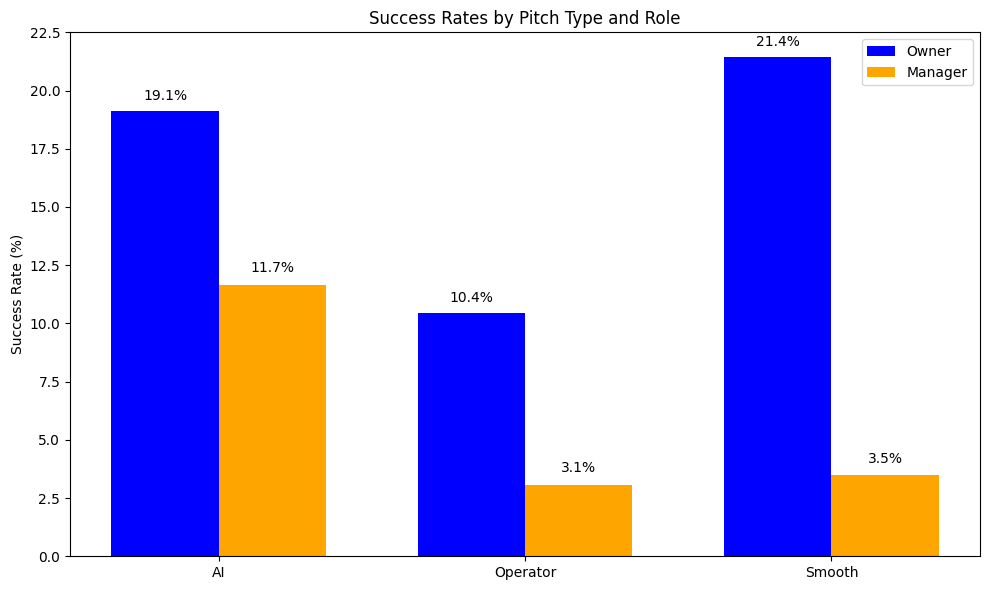

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

categories = pivot_table.columns  # Pitch types (AI, Smooth Revenue, Operator)
owner_success = pivot_table.loc['Owner'].values  # Owner success rates
manager_success = pivot_table.loc['Manager'].values  # Manager success rates

#  x positions for bars
x = np.arange(len(categories))
width = 0.35  # Width of bars

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, owner_success, width, label='Owner', color='blue')
bars2 = ax.bar(x + width/2, manager_success, width, label='Manager', color='orange')

# Adding labels, title, and customizations
ax.set_ylabel('Success Rate (%)')
ax.set_title('Success Rates by Pitch Type and Role')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Annotating the bars with success rates
for bars in [bars1, bars2]:
    for bar in bars:
        yval = round(bar.get_height(),1)  # Round the percentage to nearest integer
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval}%', ha='center')


plt.tight_layout()
plt.show()
